In [11]:
# ! pip install --upgrade openai

In [20]:
import os
from openai import AzureOpenAI
import json

import os
os.environ["AZURE_OPENAI_API_KEY"] = ""
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sustainabilitycopilot.openai.azure.com/"
os.environ["OPENAI_GPT_DEPLOYMENT"] = "gpt-4o"
api_version="2024-05-01-preview"
os.environ["AZURE_OPENAI_API_VERSION"] = api_version

client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION')
)


In [21]:
# Don't reupload the file if it already exists

file = client.files.create(
    file=open("Emissions.xlsx", "rb"),
    purpose="assistants"
)

In [22]:
print(file.id)

assistant-JSSroeEhvC97hisVPTkj3t2H


In [23]:
import time

list_assistants = client.beta.assistants.list()
assistant_ID = None
for assistant in list_assistants:
    # print(assistant.id, assistant.name)
    if assistant.name == "SustainabilityInsights331":
        assistant_ID = assistant.id

if assistant_ID is None:
    print("Creating new assistant")
    client.beta.assistants.create(
        name="SustainabilityInsights331",
        temperature=0,
        instructions="""You are sustainability copilot and you are supposed to answer user's queries using the data present in Emissions.xlsx (database).
        Generate graphs wherever possible to give more insights about the user's emissions. Try to give detailed and formatted report about the emission for the user's question. 
        """,
        tools=[{"type": "code_interpreter"}],
        model="gpt-4o",
        tool_resources={
        "code_interpreter": {
                "file_ids": [file.id]
            }
        }
    )
    
    assistant_ID = assistant.id
    time.sleep(10)


In [24]:
assistant = client.beta.assistants.retrieve(assistant_id=assistant_ID)

In [25]:
thread = client.beta.threads.create()
print("Thread id: ", thread.id)

Thread id:  thread_VkZzXIjEc2cXWZif5JF4pydF


In [26]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What were my total emissions in 2023? Show the yearly trend.",
)

When you run the thread, you can provide extra instructions via the `instructions` parameter.

A thread is run asychronously. We need to check the run status to see if it is done. After you run the cell below, keep running the cell under it until the status is `completed`. When it is not completed, the status is `in_progress`.

Other statuses: cancelled, expired, failed

In [27]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [28]:
print("processing")
while True:
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    status = run.status
    if status == "completed":
        break
    time.sleep(1)

# dump the messages on the thread again
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)



processing


In [29]:
messages_json = json.loads(messages.model_dump_json())

What were my total emissions in 2023? Show the yearly trend.

### Report on Total Emissions in 2023

Based on the data provided:

- **Total Emissions for the Year 2023**: 6.53 units

#### Monthly Breakdown of Emissions in 2023:
- January: 0.54 units
- February: 0.22 units
- March: 0.37 units
- April: 0.20 units
- May: 0.58 units
- June: 0.58 units
- July: 2.18 units
- August: 0.35 units
- September: 0.31 units
- October: 0.35 units
- November: 0.28 units
- December: 0.57 units

#### Yearly Trend of Total Emissions:
The graph above shows the yearly trend of total emissions from 2022 to 2024. In 2023, the total emissions are observed to be higher compared to 2022 but decrease in 2024.

| Year | Total Emissions (units) |
|------|-------------------------|
| 2022 | 6.09                    |
| 2023 | 6.53                    |
| 2024 | 4.38                    |

The monthly breakdown and the yearly trend provide a detailed insight into the emission patterns and help identify periods of higher emissions, which could be useful in planning and sustainability efforts.

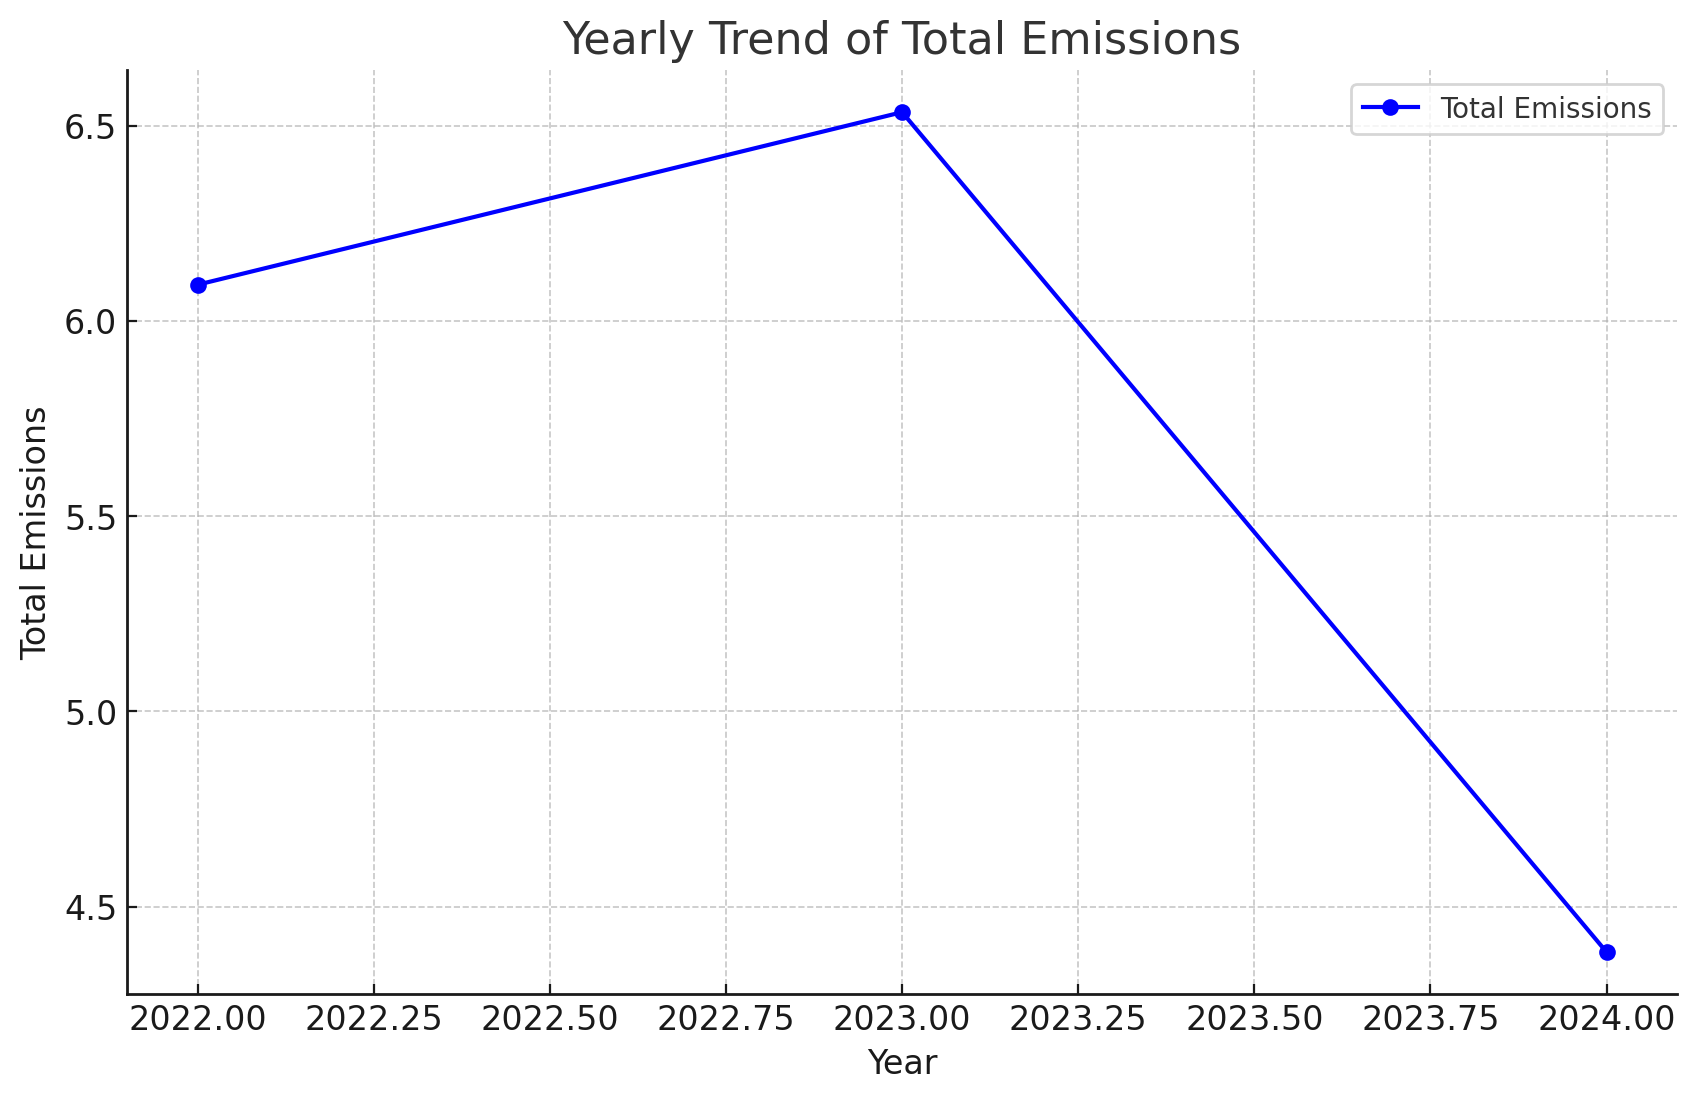

In [30]:
from PIL import Image
from IPython.display import display, Markdown

for item in reversed(messages_json['data']):
    for content in reversed(item['content']):
        if 'text' in content:
            display(Markdown(content['text']['value']))
        if 'image_file' in content:
            file_id = content['image_file']['file_id']
            file_content = client.files.content(file_id)
            img = Image.open(file_content)
            display(img)
            
            


#### Create a new thread

In [31]:
thread = client.beta.threads.create()
print("Thread id: ", thread.id)

Thread id:  thread_Wg8RD9Rl0dukcTU6ikiDN82I


In [32]:
from PIL import Image
from IPython.display import display, Markdown

def generate_answer_agent_CI(message, client, thread):
    if thread == None:
        thread = client.beta.threads.create()

    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )

    print("processing")
    while True:
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id
        )
        status = run.status
        if status == "completed":
            break
        time.sleep(1)

    # dump the messages on the thread again
    messages = client.beta.threads.messages.list(
    thread_id=thread.id
    )

    messages_json = json.loads(messages.model_dump_json())

    for item in reversed(messages_json['data']):
        for content in reversed(item['content']):
            if 'text' in content:
                display(Markdown(content['text']['value']))
            if 'image_file' in content:
                file_id = content['image_file']['file_id']
                file_content = client.files.content(file_id)
                img = Image.open(file_content)
                display(img)

    return thread
                


processing


Give me the regions is having the highest carbon emissions over the last 3 years?

Let's first load the data from the uploaded file and examine its contents. Then, we'll analyze the carbon emissions data to identify the regions with the highest emissions over the last 3 years.

The dataset contains several columns, including date information, region names, and different types of carbon emissions (scope1, scope2Market, scope2Location, and scope3).

To determine which regions have the highest carbon emissions over the last 3 years, we'll need to:
1. Convert the dateKey column to a proper datetime format and filter the data for the last 3 years.
2. Aggregate the carbon emissions by region.
3. Identify the regions with the highest total carbon emissions.

Let's go ahead and perform these steps.

The regions with the highest carbon emissions over the last 3 years are as follows:

1. **East US 2**
   - Scope 1 Carbon Emission: 0.022122
   - Scope 2 Market Carbon Emission: 0.0
   - Scope 2 Location Carbon Emission: 1.275056
   - Scope 3 Carbon Emission: 1.062326
   - Total Carbon Emission: 2.359504

2. **Brazil South**
   - Scope 1 Carbon Emission: 0.035767
   - Scope 2 Market Carbon Emission: 0.0
   - Scope 2 Location Carbon Emission: 0.387849
   - Scope 3 Carbon Emission: 1.738115
   - Total Carbon Emission: 2.161731

3. **North Central US**
   - Scope 1 Carbon Emission: 0.014075
   - Scope 2 Market Carbon Emission: 0.0
   - Scope 2 Location Carbon Emission: 1.574945
   - Scope 3 Carbon Emission: 0.572078
   - Total Carbon Emission: 2.161098

4. **West US 3**
   - Scope 1 Carbon Emission: 0.002088
   - Scope 2 Market Carbon Emission: 0.0
   - Scope 2 Location Carbon Emission: 1.177264
   - Scope 3 Carbon Emission: 0.578561
   - Total Carbon Emission: 1.757913

5. **East US**
   - Scope 1 Carbon Emission: 0.011011
   - Scope 2 Market Carbon Emission: 0.0
   - Scope 2 Location Carbon Emission: 0.737600
   - Scope 3 Carbon Emission: 0.850662
   - Total Carbon Emission: 1.599273

Let's visualize this data in a bar chart to give more insights.

The bar chart above displays the total carbon emissions for the top regions over the last 3 years. It is evident that "East US 2" has the highest carbon emissions, followed by "Brazil South" and "North Central US."

If you have any further questions or need a more detailed analysis, please let me know!

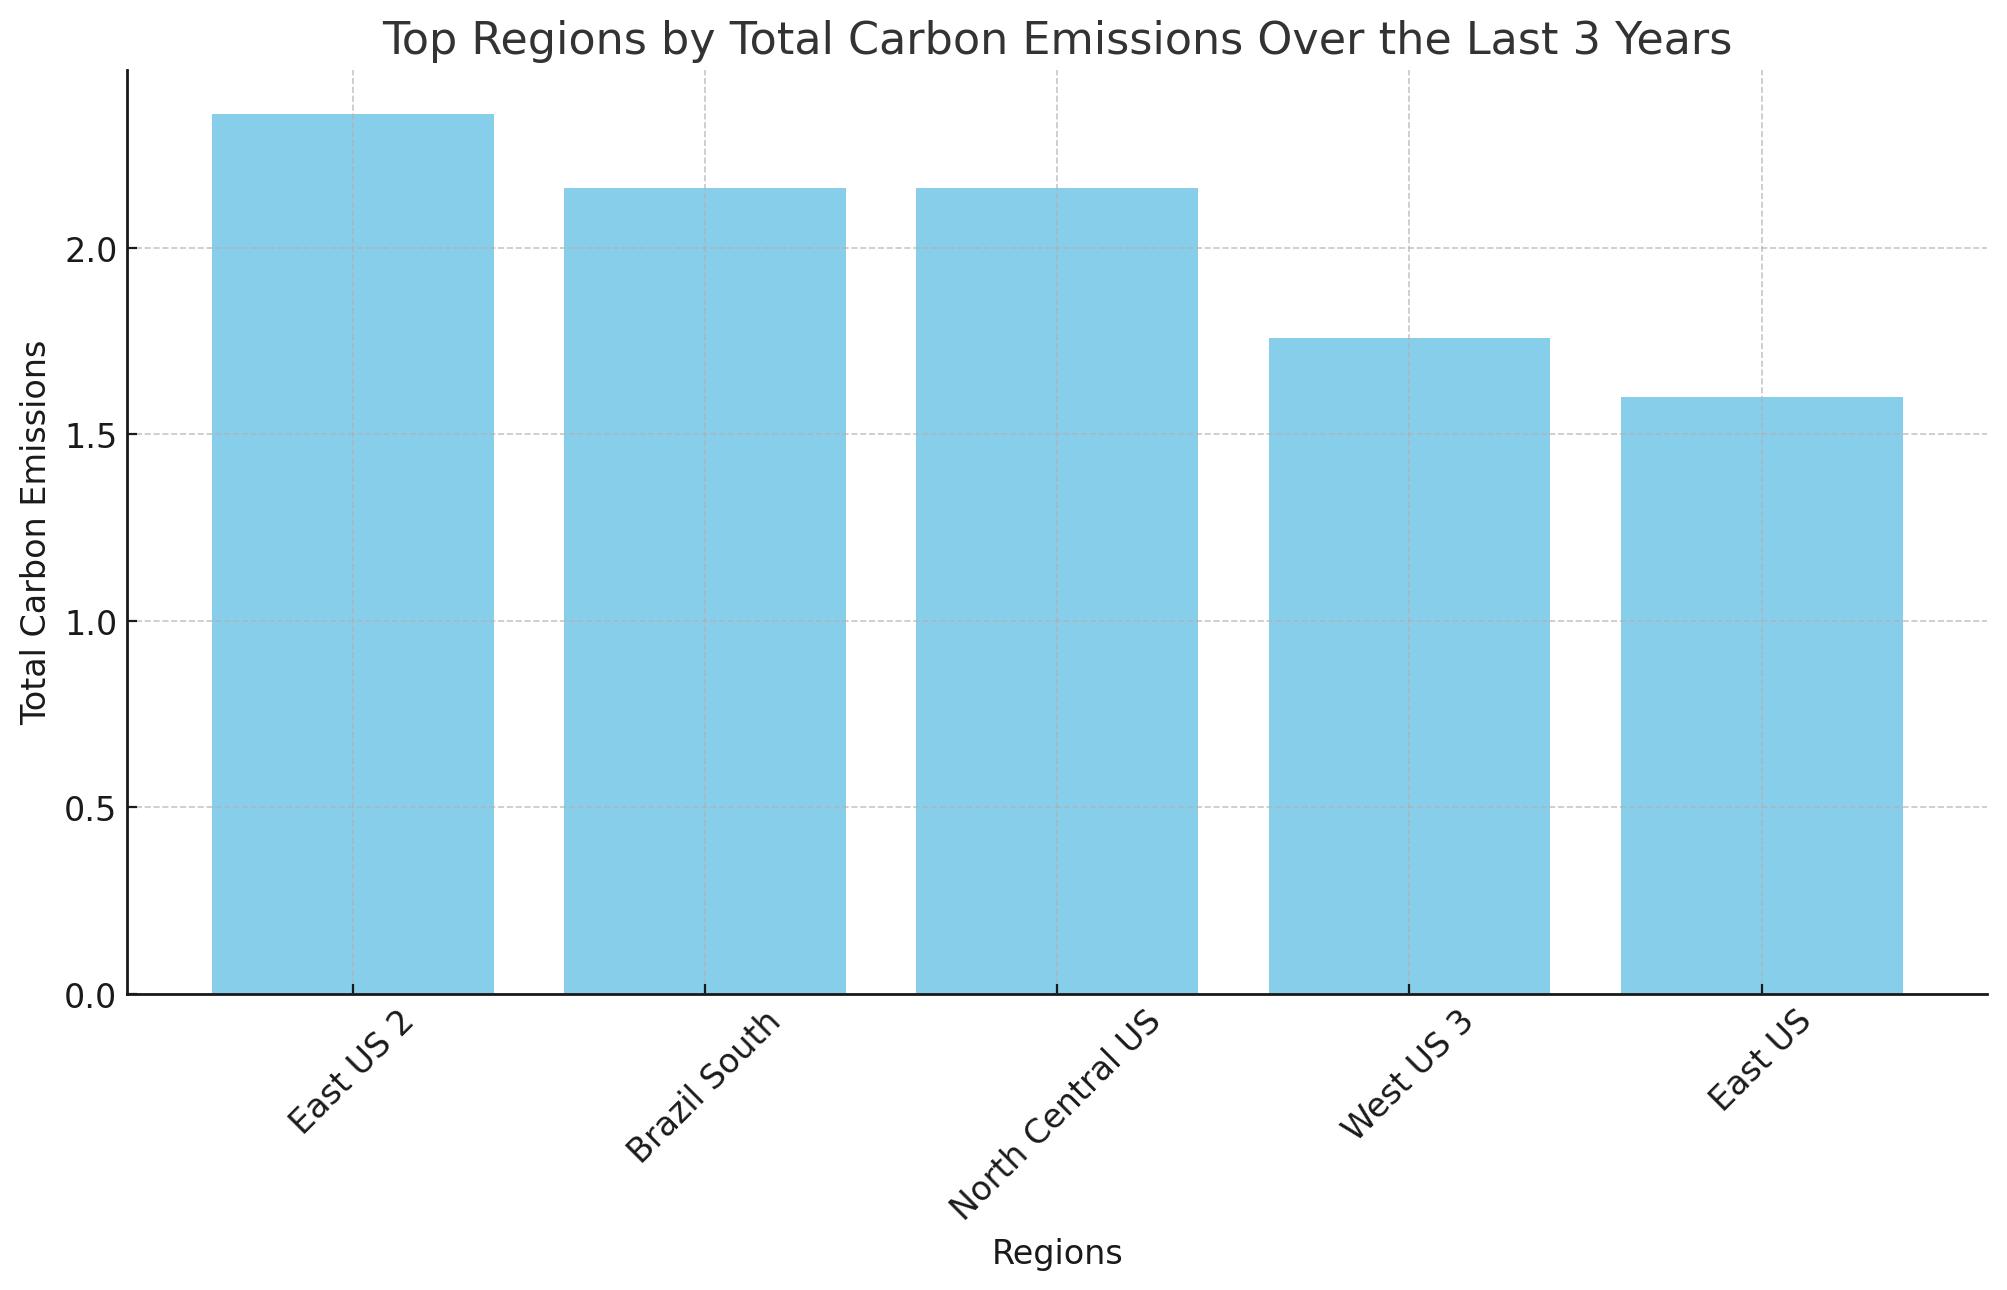

In [33]:
prompt = "Give me the regions is having the highest carbon emissions over the last 3 years?"

thread = generate_answer_agent_CI(message=prompt, client=client, thread=None)

In [34]:
prompt = "Can you give me the total usage of Azure storage in US for Qtr 2 2023?"
thread = generate_answer_agent_CI(message=prompt, client=client, thread=None)

processing


Can you give me the total usage of Azure storage in US for Qtr 2 2023?

The total Azure storage usage in the US for the 2nd quarter of 2023 is approximately 750.08 units. 

Would you like a detailed breakdown or visual representation of this data?

processing


What is the YoY increase/decrease in Scope 3 emissions from compute Service for Europe

Let me first take a look at the data in the uploaded file so that I can understand its structure and contents. After that, I will analyze the Year-over-Year (YoY) changes in Scope 3 emissions from compute services for Europe.

The Excel file contains a single sheet, named "Sheet1". I will now load the data from this sheet and take a look at its contents to identify the relevant columns for Scope 3 emissions from compute services in Europe.

The dataset contains several columns, including:

- `dateKey`: The date of the record (seems to be in YYYYMMDD format)
- `azureRegionDisplayName`: The region (e.g., "West Europe")
- `scope3CarbonEmission`: The Scope 3 carbon emissions
- `meteredService`: The type of service (e.g., "ClassicStorage")

To answer the query, I will filter the data for "compute Service" in the "meteredService" column as well as "Europe" in the "azureRegionDisplayName" column. After that, I will calculate the Year-over-Year increase or decrease in Scope 3 emissions.

Let's proceed with the analysis.

The data contains Scope 3 carbon emissions for compute services in Europe for the years 2022, 2023, and 2024. Here is the summary:

| Year | Scope 3 Carbon Emissions (tons) |
|------|-------------------------------|
| 2022 | 0.026730                      |
| 2023 | 0.033316                      |
| 2024 | 0.007304                      |

I will now calculate the Year-over-Year (YoY) changes in the emissions and plot the results for better visualization.

Here is the detailed Year-over-Year (YoY) analysis of Scope 3 emissions from compute services in Europe:

- In 2022, the Scope 3 carbon emissions were 0.026730 tons.
- In 2023, the emissions increased to 0.033316 tons, which represents a YoY increase of approximately **24.64%**.
- In 2024, the emissions decreased to 0.007304 tons, which represents a YoY decrease of approximately **78.08%**.

The bar chart above visualizes these changes:

- The blue bars indicate the total Scope 3 carbon emissions for each year.
- The markers and line provide a continuous view of the emissions over the years.
- The text labels on the chart show the YoY percentage changes.

This visualization and analysis provide a clear picture of how Scope 3 emissions from compute services in Europe have fluctuated over the years.

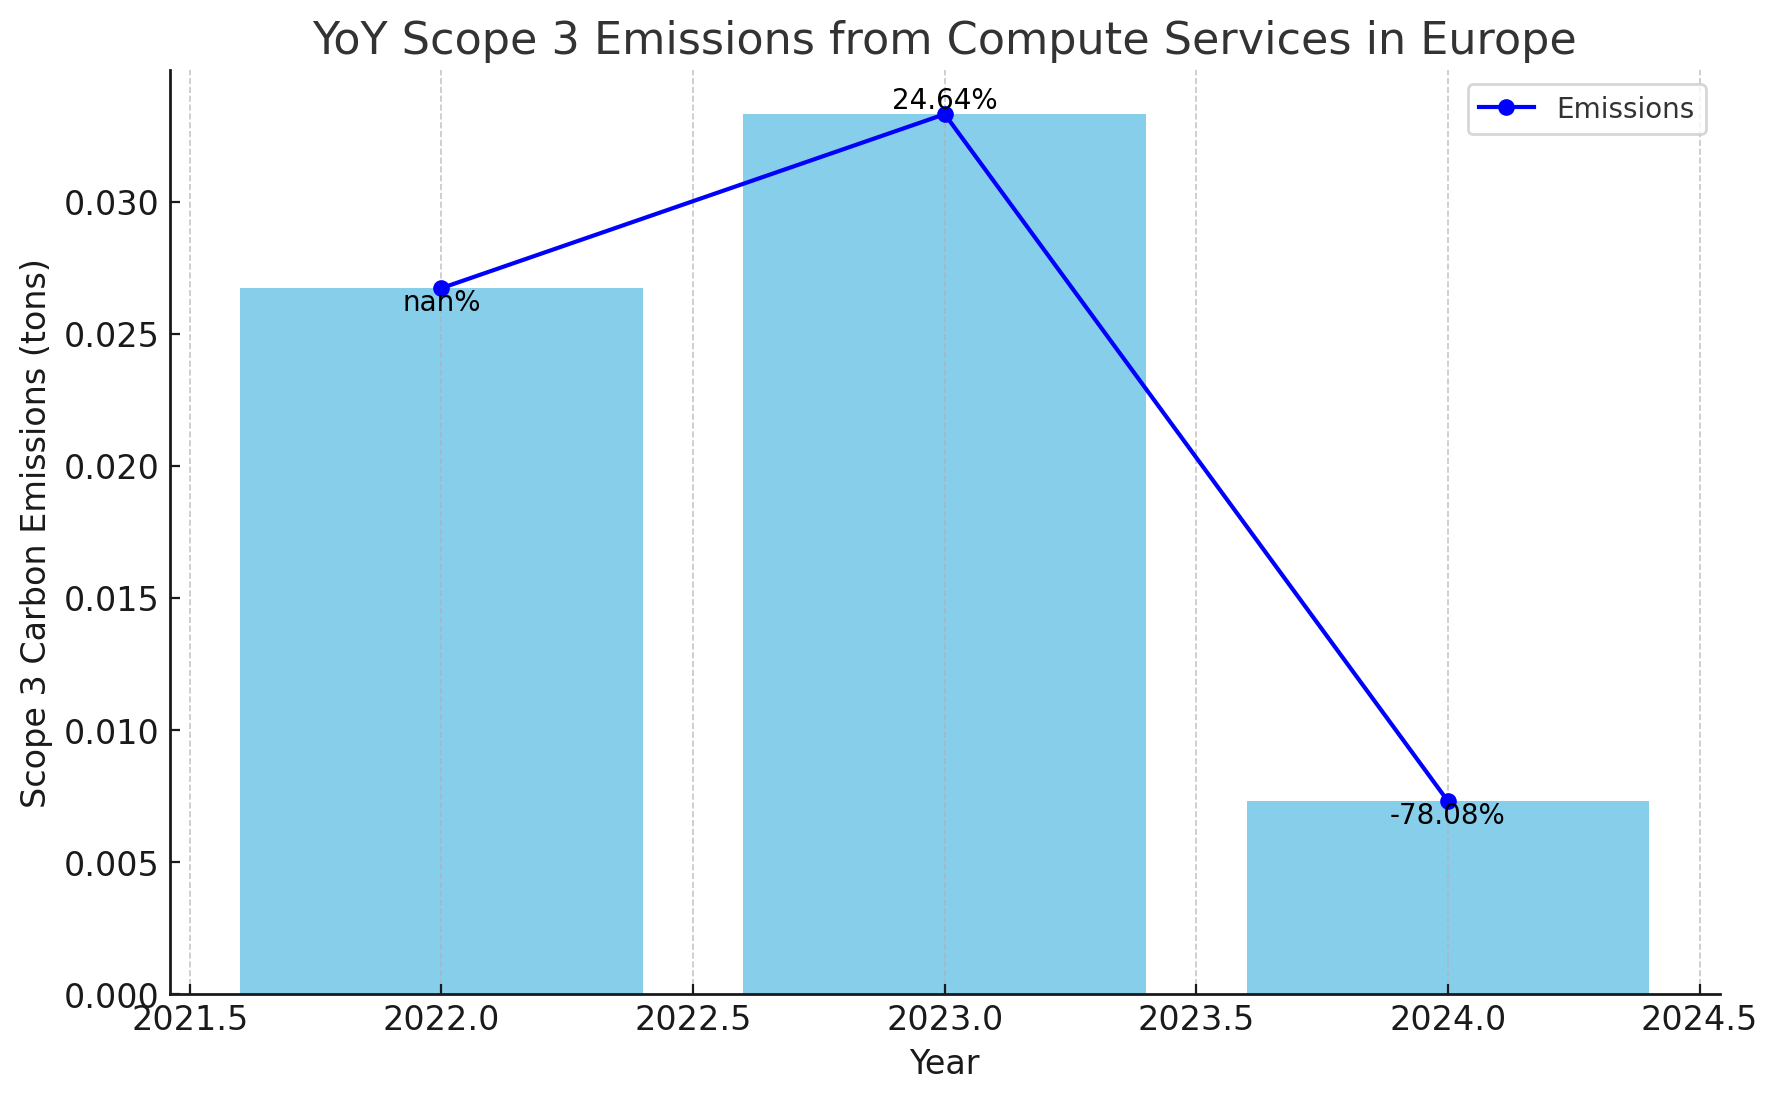

In [27]:
prompt = "What is the YoY increase/decrease in Scope 3 emissions from compute Service for Europe"

thread = generate_answer_agent_CI(message=prompt, client=client, thread=None)

processing


Can you give me the top 5 subscriptions and the services which are contributing to maximum Scope 3 emissions in 2023?

Sure, let me first examine the content of the uploaded file "Emissions.xlsx" to understand the structure and the data it contains, especially relevant to Scope 3 emissions.

The Excel file contains one sheet named "Sheet1". I will now load the data from this sheet to examine its contents.

The dataset contains extensive information about various subscriptions and their corresponding carbon emissions. Notably, we have the following relevant columns for your query:
- `subscriptionId`
- `subscriptionName`
- `meteredService`
- `scope3CarbonEmission`
- `dateKey` (for the date information)

To provide the top 5 subscriptions and the services contributing to the maximum Scope 3 emissions in 2023, I'll first filter the data for the year 2023, then group by subscription and service, and finally summarize and sort the emissions.

### Top 5 Subscriptions and Services Contributing to Maximum Scope 3 Emissions in 2023

Based on the data provided for the year 2023, here are the top 5 subscriptions and their corresponding services that contribute the most to Scope 3 carbon emissions:

1. **Subscription:** TESTSUBSNAME1DEMO
   - **Service:** CognitiveServices
   - **Scope 3 Carbon Emission:** 1.735678 tons

2. **Subscription:** TESTSUBSNAME1DEMO
   - **Service:** Search
   - **Scope 3 Carbon Emission:** 0.455452 tons

3. **Subscription:** TESTSUBSNAME1DEMO
   - **Service:** MachineLearningServices
   - **Scope 3 Carbon Emission:** 0.258875 tons

4. **Subscription:** ACCOUNT1_SUBSCRIPTION1
   - **Service:** web
   - **Scope 3 Carbon Emission:** 0.109337 tons

5. **Subscription:** PRODUCTION_SUBSCRIPTION1
   - **Service:** Compute
   - **Scope 3 Carbon Emission:** 0.097954 tons

To provide further insights, let's visualize the contributions of these top 5 subscriptions and services using a bar chart.

### Visualization

The bar chart above provides a clear illustration of the top 5 subscriptions and their services contributing to Scope 3 carbon emissions in 2023. It highlights the significant contributors, with "TESTSUBSNAME1DEMO - CognitiveServices" being the highest.

This detailed report allows you to identify the major contributors and consider steps to manage or reduce the associated carbon emissions effectively. If you have any further questions or need additional analysis, feel free to ask!

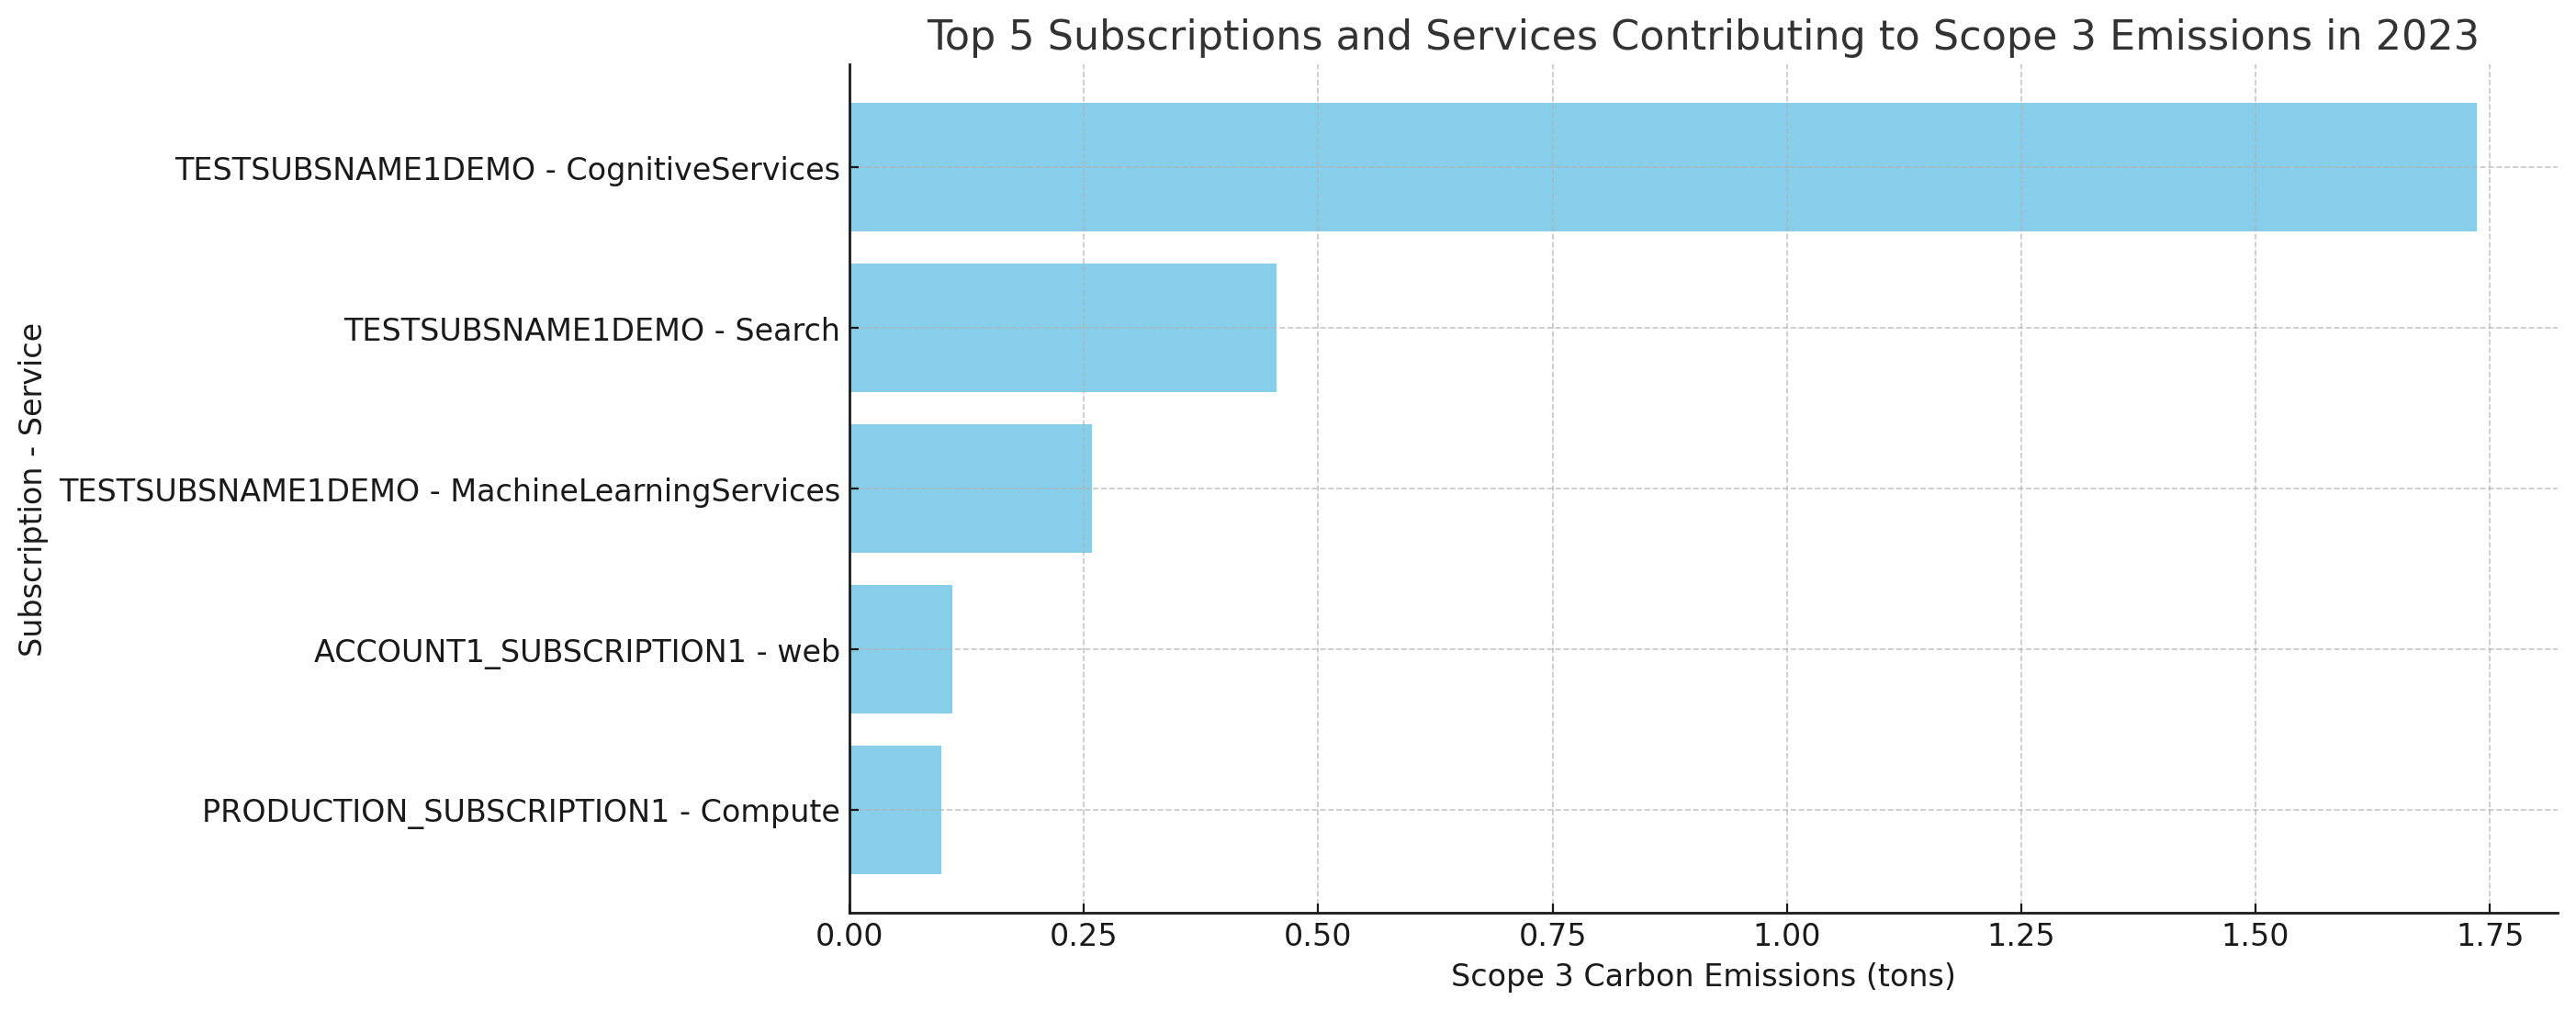

In [28]:
prompt = "Can you give me the top 5 subscriptions and the services which are contributing to maximum Scope 3 emissions in 2023?"
thread = generate_answer_agent_CI(message=prompt, client=client, thread=None)